# Markov Decision Process (MDP)

### Ransalu Senanayake

In [ ]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [39]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    goal_states = [99]
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy, 'goal': goal_states}

In [40]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.gamma = 0.9
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']
        self.goal = mdp_dict['goal']

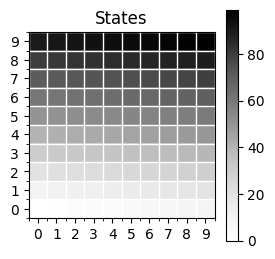

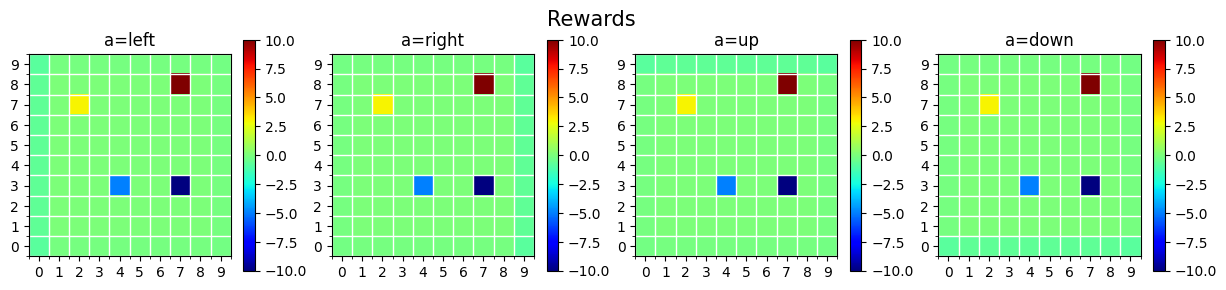

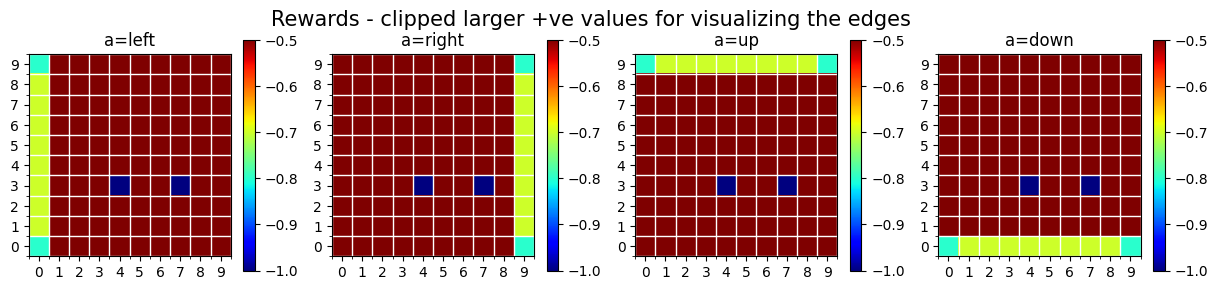

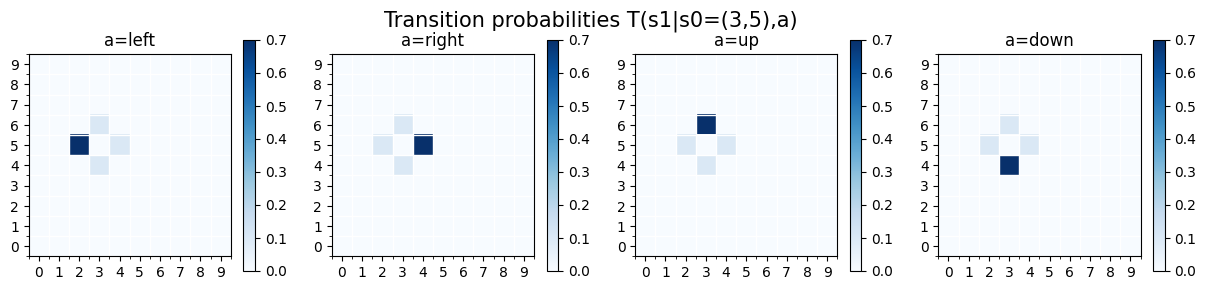

In [41]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [42]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

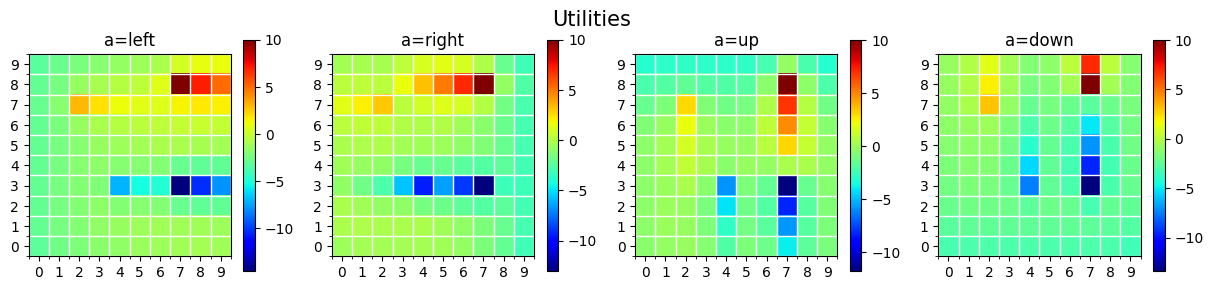

In [43]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      #type your code here
        for s in range(len(mdp.S)):
            new_U = 0
            for s_prime in range(len(mdp.S)):
                new_U += mdp.T[s, policy, s_prime] * U_old[s_prime]
            # Use mdp.discount instead of mdp.gamma
            U[s] = mdp.R[s, policy] + mdp.discount * new_U
            U_old = U.copy()
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [44]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

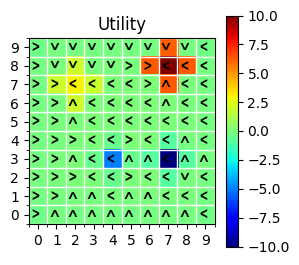

In [45]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      #type your code here
        for s0 in range(len(mdp.S)):
            U[s0] = max([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_old[:]) for a in np.arange(len(mdp.A))])
        U_old = copy.copy(U)
    return U

def policyExtration(mdp, U):
    policy = np.zeros(len(mdp.S))
    #type your code here
    for s0 in range(len(mdp.S)):
        policy[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U[:]) for a in np.arange(len(mdp.A))])
    return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [46]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [47]:
def policyIteration(mdp, numIterations=1):
    U_pi_k = np.zeros(len(mdp.S)) #initial values
    pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
    pi_kp1 = copy.copy(pi_k)
    for t in range(numIterations):
        #Policy evaluation: compute U_pi_k
        #type your code here
        U_pi_k_temp = copy.copy(U_pi_k)
        pi_k = copy.copy(pi_kp1)
        for s0 in range(len(mdp.S)):
            U_pi_k[s0] = mdp.R[s0,pi_k[s0]] + mdp.discount*np.sum(mdp.T[s0,pi_k[s0],:]*U_pi_k_temp[:])
        #Policy improvement
        #type your code here
        for s0 in range(len(mdp.S)):
            pi_kp1[s0] = np.argmax([mdp.R[s0,a] + mdp.discount*np.sum(mdp.T[s0,a,:]*U_pi_k[:]) for a in np.arange(len(mdp.A))])
    return U_pi_k, pi_kp1

U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [48]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

# **Define the Neural Network**

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# **DQN Agent Class**

In [55]:
class DQNAgent:
    def __init__(self, state_size, action_size, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return np.argmax(act_values.detach().numpy())  # returns action

    def replay(self, batch_size): # Fixed indentation here
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model(torch.FloatTensor(next_state)).detach().numpy())

            # Change here: squeeze target_f to remove extra dimension,
            # this will make target_f to have a size of (action_size,)
            target_f = self.model(torch.FloatTensor(state)).detach().numpy().squeeze(0)

            target_f[action] = target
            target_f = torch.FloatTensor(target_f)
            self.optimizer.zero_grad()
            output = self.model(torch.FloatTensor(state))
            loss = self.criterion(output, target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# **Action Function & Training the DQN Agent**

In [59]:
import numpy as np

def take_action(action, state, gridWorld):
    """
    Takes an action in the grid world and returns the next state, reward, and done flag.
    """
    # Get current row and column from state
    current_row = state[0][0]

    # Define actions (0: up, 1: down, 2: left, 3: right)
    if action == 0:  # Up
        next_row = max(0, current_row - 1)
    elif action == 1:  # Down
        next_row = min(gridWorld['S'].shape[0] - 1, current_row + 1)
    elif action == 2:  # Left
        next_row = current_row  # No change in row for left/right in 1D grid
    elif action == 3:  # Right
        next_row = current_row  # No change in row for left/right in 1D grid
    else:
        raise ValueError("Invalid action. Action must be in [0, 1, 2, 3]")

    # Get next state
    next_state = gridWorld['S'][next_row]

    # Check if the next state is terminal
    done = next_state in gridWorld['goal']

    # Calculate reward
    if done:
        reward = gridWorld['R'][next_row][0]  # Reward for reaching the goal state
    else:
        reward = gridWorld['R'][next_row][0]  # Reward for other states

    return next_state, reward, done


def train_with_epsilon(gridWorld, epsilon_values, episodes=1000, batch_size=32):
    # Check the shape of gridWorld['S']
    print(f"Shape of gridWorld['S']: {gridWorld['S'].shape}")

    # Check if gridWorld['S'] is 1-dimensional and reshape if necessary
    if len(gridWorld['S'].shape) == 1:
        state_size = 1  # If 1D, there's only one feature per state
        gridWorld['S'] = gridWorld['S'].reshape(-1, 1) # Reshape to 2D with one column
    else:
        state_size = gridWorld['S'].shape[1]  # Otherwise, use the second dimension

    action_size = len(gridWorld['A'])

    results = {}

    for epsilon in epsilon_values:
        agent = DQNAgent(state_size, action_size, epsilon)
        print(f"Training with epsilon = {epsilon}")
        scores = []

        for e in range(episodes):
            # Reset the environment to a random initial state
            state = gridWorld['S'][np.random.choice(gridWorld['S'].shape[0])]
            state = np.reshape(state, [1, state_size])
            score = 0

            for time in range(500):  # Time steps
                action = agent.act(state)  # Choose action based on the current state and epsilon

                # Call take_action with gridWorld
                next_state, reward, done = take_action(action, state, gridWorld)  # Execute action

                # Ensure the new state is reshaped correctly
                next_state = np.reshape(next_state, [1, state_size])
                agent.remember(state, action, reward, next_state, done)  # Store experience
                state = next_state  # Move to the next state
                score += reward  # Update score

                if done:
                    break

            scores.append(score)  # Store the score for each episode

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)  # Learn from experience

        # Store average scores over the episodes for plotting
        results[epsilon] = np.convolve(scores, np.ones(100)/100, mode='valid')  # Moving average

    return results

# **Call the Training Function**

In [60]:
# Initialize the environment
gridWorld = createGrid10World()  # Call the function to create the grid world

# Define different epsilon values to test
epsilon_values = [0.1, 0.5, 0.9]

# Train with different epsilon values
results = train_with_epsilon(gridWorld, epsilon_values, episodes=1000, batch_size=32)


Shape of gridWorld['S']: (100,)
Training with epsilon = 0.1
Training with epsilon = 0.5
Training with epsilon = 0.9


# **Analyzing Results**

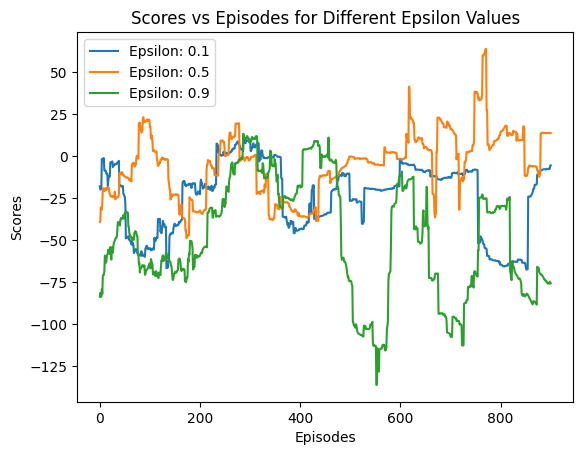

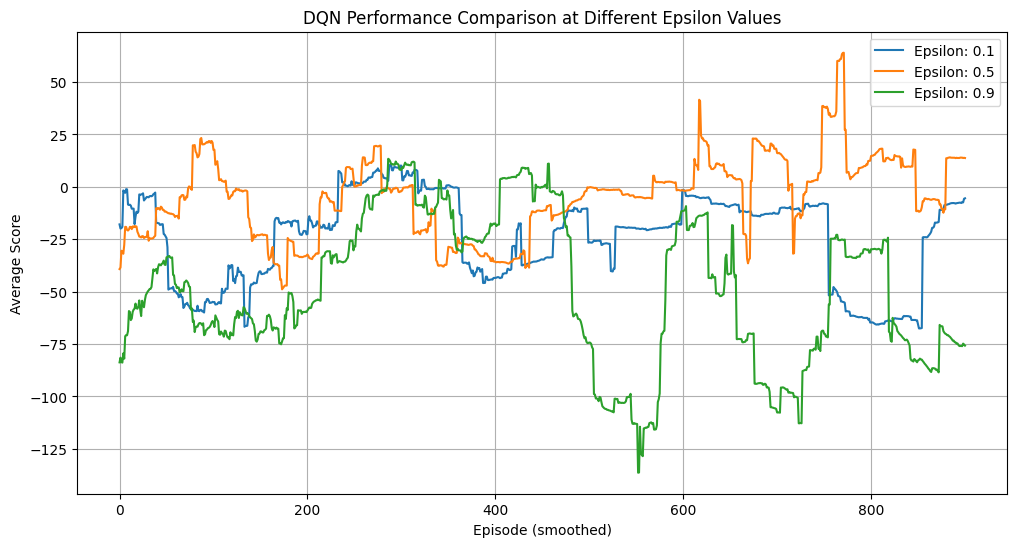

In [61]:
import matplotlib.pyplot as plt

def plot_results(results):
    for epsilon, scores in results.items():
        plt.plot(scores, label=f"Epsilon: {epsilon}")
    plt.xlabel("Episodes")
    plt.ylabel("Scores")
    plt.legend()
    plt.title("Scores vs Episodes for Different Epsilon Values")
    plt.show()

# Plot the results
plot_results(results)

# Plotting the results
plt.figure(figsize=(12, 6))
for epsilon, scores in results.items():
    plt.plot(scores, label=f'Epsilon: {epsilon}')
plt.title('DQN Performance Comparison at Different Epsilon Values')
plt.xlabel('Episode (smoothed)')
plt.ylabel('Average Score')
plt.legend()
plt.grid()
plt.show()
